#**Stochastic Linear Program for Evacuation Planning In Disaster Responses**
Import some libraries with appropriate uses:
*   **networkx**: generating road network.
*   **matplotlib.pyplot**: drawing road network.
*   **numpy**: creating, manipulating matrices and perform matrcies operations.

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

#**Generating and ploting road network**
| Variable | Description | Data Type | Value or range|
| :-: | :- | :-: | |
| size_row | Number of rows in grid | int | size_row $\geq$ 0|
| size_col | Number of columns in grid | int | size_col $\geq$ 0|
| numNode | Number of nodes in grid | int | 0 $\leq$ numNode $\leq$ size_row $\times$ size_col|
| d | Supply value of source node | int | d $\geq$ 0|
| pen | Penalty on link $(i,j)$ | int | 30 $\leq$ pen $\leq$ 100|
| alpha | $\Sigma_{S=1}^S \Sigma_{t \leq\widetilde{T}} \ \alpha_{ij}^S(t)$ on link $(i,j)$ | int | 1 $\leq$ alpha $\leq$ 10|
| cost | Generalized cost $g_{ij}$ on link $(i,j)$ | int |cost$_{ij}$ = pen - alpha|

Enter the number of rows:
3
Enter the number of columns:
2
Enter the number of node:
6
Enter supply value:
10


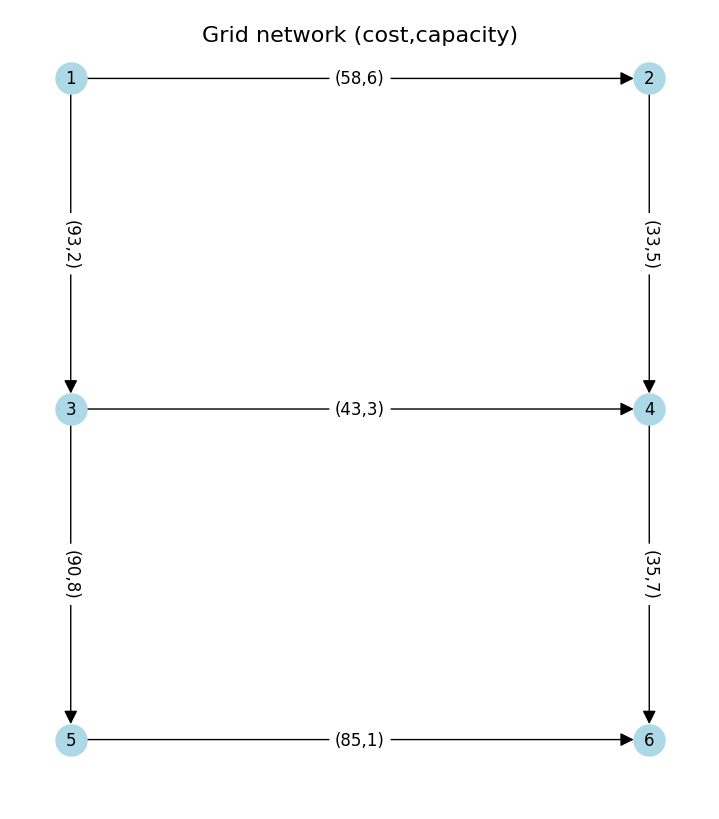

Cost Matrix:
[[ 0 58 93  0  0  0]
 [ 0  0  0 33  0  0]
 [ 0  0  0 43 90  0]
 [ 0  0  0  0  0 35]
 [ 0  0  0  0  0 85]
 [ 0  0  0  0  0  0]]
Capacity Matrix:
[[0 6 2 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 3 8 0]
 [0 0 0 0 0 7]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]]


In [ ]:
G = nx.DiGraph()
print("Enter the number of rows:")
size_row = int(input())
print("Enter the number of columns:")
size_col = int(input())
print("Enter the number of node:")
numNode = int(input())
while numNode > size_row*size_col:
  print("Error, please enter the number of node again:")
  numNode = int(input())
print("Enter supply value:")
d = int(input())
np.random.seed(1)
#Add nodes and edges to the graph

node_label = 1
labels = {}
for i in range(size_row):
    for j in range(size_col):
        if node_label == numNode + 1:
          break
        node = (i, j)
        G.add_node(node)
        labels[node] = node_label
        node_label += 1
        if i > 0:
            pen = np.random.randint(low = 30, high = 100)
            alpha = np.random.randint(low = 1, high = 10)
            G.add_edge((i-1, j), node, cost = pen - alpha, capacity =  np.random.randint(low = 1, high = 10))  # Add edge from the node above
        if j > 0:
            pen = np.random.randint(low = 30, high = 100)
            alpha = np.random.randint(low = 1, high = 10)
            G.add_edge((i, j-1), node,cost = pen - alpha, capacity =  np.random.randint(low = 1,high = 10))  # Add edge from the node on the left

#Draw the graph
pos = {(x, y): (y, -x) for x, y in G.nodes()}  # Position nodes in a grid layout
plt.figure(figsize = (size_col+5,size_row+5))
plt.suptitle('Grid network (cost,capacity)', fontsize=16)
Elabels = {(u,v): f"({G[u][v]['cost']},{G[u][v]['capacity']})" for u,v in G.edges()}
nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=500, arrowsize=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels = Elabels, font_size = 12)
plt.show()

#Index starts from 00
matrixCost = nx.adjacency_matrix(G, weight = "cost")
matrixCapacity = nx.adjacency_matrix(G, weight = "capacity")
matrixFlow = np.full((numNode,numNode), -1)

for i in range(numNode):
  for j in range(numNode):
    if matrixCost[i,j] != 0:
      matrixFlow[i,j] = 0
print("Cost Matrix:")
print(matrixCost.todense())
print("Capacity Matrix:")
print(matrixCapacity.todense())


#**Label-correting and Successive shortest path algorithm**

In [ ]:
from math import inf
def label_correct(numNode, matrixCost, matrixCapacity):
  smallestCapacity = inf
  #FIFO
  #Initialize array containing values of labels
  node_label = [inf for i in range(numNode)]
  node_label[0] = 0
  #Initialize array to backtrack
  parent = [-1 for i in range(numNode)]
  #Initialize array visit
  visited = [False for i in range(numNode)]

  queue=[]
  queue.append(0)
  visited[0] = True
  upper = inf
  shortest_path = []


  while len(queue) != 0:
    i = queue[0]
    queue.pop(0)
    for j in range(numNode):
      #print('1')
      if matrixCost[i,j] != 0 and matrixCapacity[i,j] !=0:
        if node_label[i] + matrixCost[i,j] < min(node_label[j], upper):
          node_label[j] = node_label[i] + matrixCost[i,j]
          parent[j] = i
          if j != numNode -1:
            if visited[j] == False:
              queue.append(j)
              visited[j] = True
          else:
            upper = node_label[i] + matrixCost[i,j]
    visited[i] = False

  node = numNode - 1

  while parent[node] != -1:
    shortest_path.insert(0,node)
    smallestCapacity = min(smallestCapacity, matrixCapacity[parent[node], node])
    node = parent[node]
  shortest_path.insert(0,0)

  return shortest_path, smallestCapacity, upper

##############################################################################################################

def successiveShortestPath(numNode, matrixCost, matrixCapacity, matrixFlow,d):
  shortestPath, smallestCapacity,upper = label_correct(numNode, matrixCost, matrixCapacity)
  size_shortestPath = len(shortestPath)
  print("shortestPath : ",end="")
  for s in shortestPath:
    print(s + 1, " ", end = "")

  if smallestCapacity > d and smallestCapacity != inf:
    smallestCapacity = d
    print("The increased flow value exceed the supply value")

  print("\nsmallestCapacity =", smallestCapacity)
  for i in range(size_shortestPath-1):
    if matrixFlow[shortestPath[i], shortestPath[i+1]] == -1:
      matrixFlow[shortestPath[i+1], shortestPath[i]] -= smallestCapacity
    else:
      matrixFlow[shortestPath[i], shortestPath[i+1]] += smallestCapacity

    matrixCost[shortestPath[i+1], shortestPath[i]] = -matrixCost[shortestPath[i], shortestPath[i+1]]
    matrixCapacity[shortestPath[i+1], shortestPath[i]] += smallestCapacity
    matrixCapacity[shortestPath[i], shortestPath[i+1]] -= smallestCapacity

  #print(matrixFlow)
  #print(matrixCost.todense())
  #print(matrixCapacity.todense())
  return smallestCapacity, matrixCost, matrixCapacity, matrixFlow,upper

def finalTotalcost(listPair,d,totalcost):
  for x in listPair:
    if d - x[0] >= 0:
      totalcost += x[0]*x[1]
      d -= x[0]
    else:
      totalcost += d*x[1]
      d = 0
  return d,totalcost

#**Solving Min-cost flow problem**

In [ ]:
supplyvalue = d
upper = 0
maxflow = 0
totalcost = 0
listPair = []
while d>0 and upper != inf:
  smallestCapacity, matrixCost, matrixCapacity, matrixFlow, upper = successiveShortestPath(numNode, matrixCost, matrixCapacity, matrixFlow,d)
  if upper != inf:
    maxflow += smallestCapacity
    x = (smallestCapacity,upper)
    listPair.append(x)
    tmp = d
    d -= smallestCapacity
    if(d < 0):
      print("The flow exceed the supply value of source node")
      d = 0
      upper *= tmp
    else:
      upper *= smallestCapacity
    totalcost += upper
  else:
    print("There is no minimum cost path in the residual network")
  print("upper =",upper)
  print("d =", d,"\n------------------------")

cost_MaxFlow = totalcost
while d>0:
  d, totalcost = finalTotalcost(listPair,d,totalcost)

print("supply value =", supplyvalue)
print("maxflow =" , maxflow)
print("minimum totalcost of maxflow =", cost_MaxFlow)
print("minimum totalcost to move all =", totalcost)

shortestPath : 1  2  4  6  
smallestCapacity = 5
upper = 630
d = 5 
------------------------
shortestPath : 1  3  4  6  
smallestCapacity = 2
upper = 342
d = 3 
------------------------
shortestPath : 1  
smallestCapacity = inf
There is no minimum cost path in the residual network
upper = inf
d = 3 
------------------------
supply value = 10
maxflow = 7
minimum totalcost of maxflow = 972
minimum totalcost to move all = 1350


#**Plotting flow graph for Min-cost flow problem**

In [ ]:
# Remove don't visit nodes and edges
for i in range(numNode -1):                 #the final node always -1s
  tobeRemove = True
  for j in range(numNode):
    if matrixFlow[i,j] == 0:
      for x in labels:
        if labels[x] == i + 1:
          u = x
        if labels[x] == j + 1:
          v = x
      G.remove_edge(u,v)

#Add Flow
B = G.copy()
for i in range(numNode -1):
  for j in range(numNode):
    if matrixFlow[i,j] != 0 and matrixFlow[i,j] != -1:
      for x in labels:
        if labels[x] == i + 1:
          u = x
        if labels[x] == j + 1:
          v = x
      G[u][v]['capacity'] = matrixFlow[i,j]

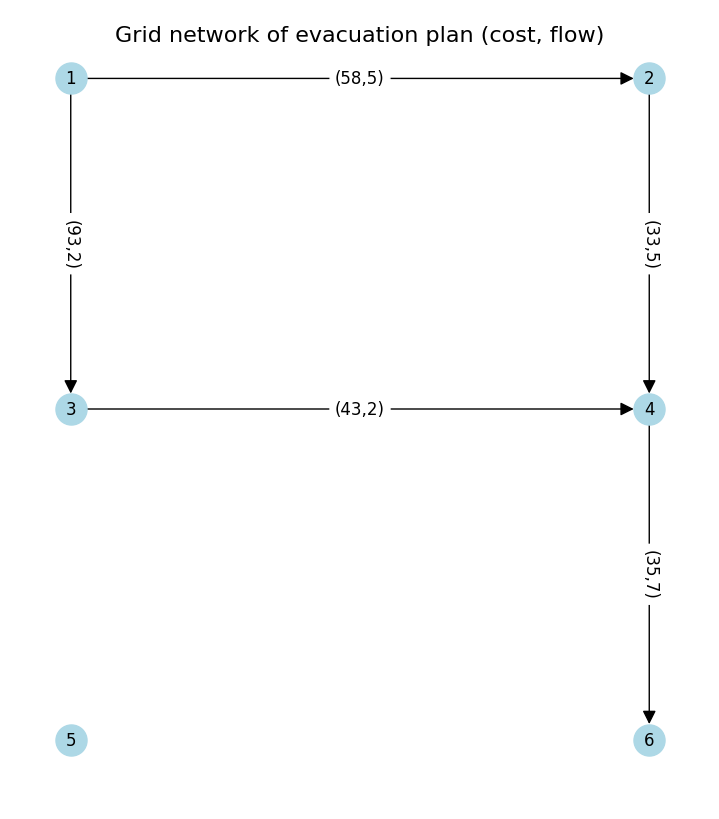

In [ ]:
pos = {(x, y): (y, -x) for x, y in G.nodes()}  # Position nodes in a grid layout
plt.figure(figsize = (size_col+5,size_row+5))
plt.suptitle('Grid network of evacuation plan (cost, flow)', fontsize=16)
Elabels = {(u,v): f"({G[u][v]['cost']},{G[u][v]['capacity']})" for u,v in G.edges()}
nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=500, arrowsize=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels = Elabels, font_size = 12)
plt.show()